In [4]:
import pandas as pd
import numpy as np
from pomegranate.distributions import Categorical
from pomegranate.distributions import ConditionalCategorical
from pomegranate.bayesian_network import BayesianNetwork

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

In [13]:
# Generate population samples from a lognormal distribution
mu, sigma, mean_population, std_population = 6.957923,0.502601,1193.0,639.5389193127133
population_samples = np.random.lognormal(mean=mu, sigma=sigma, size=1000)

# Define the bins based on the range of the lognormal distribution
bin_edges = np.histogram_bin_edges(population_samples, bins=10)

# Assign population samples to bins
population_categories = np.digitize(population_samples, bins=bin_edges, right=True)

# Calculate the probability for each bin
population_probs = np.bincount(population_categories) / len(population_categories)

# Define the categorical distribution
population_distribution = Categorical(probs=[population_probs])


/tmp/ipykernel_77/1726862075.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


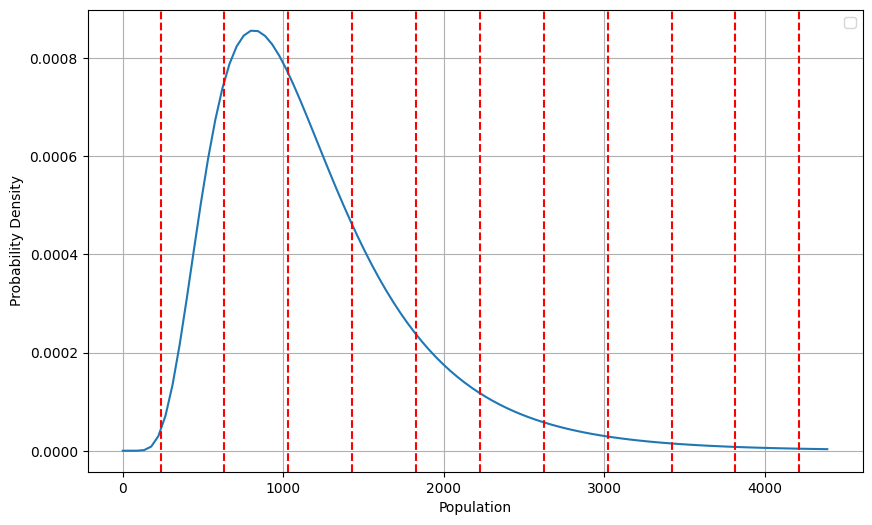

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm
# Assuming population_samples and bin_edges are already defined from the previous steps

x = np.linspace(0, mean_population + 5*std_population, 100)
# Generate the normal distribution
y = lognorm.pdf(x, s=sigma, scale=np.exp(mu))

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(x, y)
# Adding the bin edges to the plot
for edge in bin_edges:
    plt.axvline(edge, color='r', linestyle='--')
plt.xlabel('Population') 
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Generate population samples from a lognormal distribution
loc, sca, mode, GDP0, n = 0.04015352757187253,0.022034147355667708,963690.5075341386, 35808.34375, 82
# Function to compute the transformed Cauchy PDF
def transformed_cauchy_pdf(y, GDP0, n, x0, gamma):
    ln_term = np.log(y / GDP0)
    return 1 / (np.pi * gamma * y * (1 + ((ln_term - n * x0) / gamma) ** 2))
    
x_values = np.linspace(mode / 2, mode * 2, 2000)
pdf_values = transformed_cauchy_pdf(x_values, GDP0, n, loc, sca)

# Normalize the pdf_values to use as weights (so they sum to 1)
weights = pdf_values / np.sum(pdf_values)

# Randomly sample 1000 values from y_values based on the probability distribution
gdp_samples = np.random.choice(x_values, size=1000, p=weights)

# Define the bins based on the range of the lognormal distribution
bin_edges1 = np.histogram_bin_edges(gdp_samples, bins=10)

# Assign population samples to bins
gdp_categories = np.digitize(gdp_samples, bins=bin_edges1, right=True)

# Calculate the probability for each bin
gdp_probs = np.bincount(gdp_categories) / len(gdp_categories)

# Define the categorical distribution
gdp_distribution = Categorical(probs=[gdp_probs])

print(bin_edges1)

[ 528125.53827096  662338.36333224  796551.18839353  930764.01345481
 1064976.83851609 1199189.66357737 1333402.48863866 1467615.31369994
 1601828.13876122 1736040.9638225  1870253.78888379]


/tmp/ipykernel_77/1209863970.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


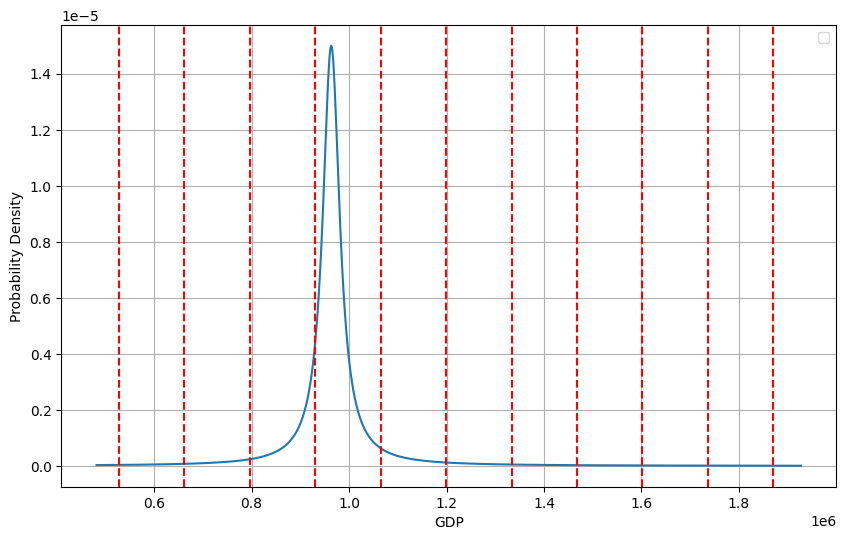

In [10]:
from scipy.stats import cauchy

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf_values)
# Adding the bin edges to the plot
for edge in bin_edges1:
    plt.axvline(edge, color='r', linestyle='--')
plt.xlabel('GDP') 
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
print("pop_bins=",bin_edges)
print("gdp_bins=",bin_edges1)

pop_bins= [ 235.83486186  633.90385496 1031.97284807 1430.04184118 1828.11083428
 2226.17982739 2624.2488205  3022.3178136  3420.38680671 3818.45579982
 4216.52479292]
gdp_bins= [ 528125.53827096  662338.36333224  796551.18839353  930764.01345481
 1064976.83851609 1199189.66357737 1333402.48863866 1467615.31369994
 1601828.13876122 1736040.9638225  1870253.78888379]


MONTE CARLO FOR CONDITIONAL


In [29]:
mu, sigma = 6.957923,0.502601
# Generate the normal distribution
num_samples = 10000  # Monte Carlo sample size

# Generate random samples from the log-normal distribution
samples_x = lognorm.rvs(sigma, scale=np.exp(mu), size=num_samples)
print(samples_x)


[1413.25251919  973.36643101  909.21894934 ... 2028.65998985  569.47408978
  584.07830736]


In [54]:
def rejection_sampling(pdf, params, num_samples, y_min, y_max):
    samples = []
    while len(samples) < num_samples:
        y = np.random.uniform(y_min, y_max)
        u = np.random.uniform(0, max_pdf)
        if u <= pdf(y, *params):
            samples.append(y)
    return np.array(samples)

# Set parameters
loc, sca, GDP0, n, mode = 0.04015352757187253,0.022034147355667708, 35808.34375, 82, 963690.5075341386

params = (GDP0, n, loc, sca)

# Define range for y (you may need to adjust this based on your specific case)
y_min, y_max = mode / 2, mode * 2

# Calculate the maximum of the PDF for rejection sampling
y_range = np.linspace(y_min, y_max, 10000)
pdf_values = transformed_cauchy_pdf(y_range, *params)
max_pdf = np.max(pdf_values)

# Generate samples
num_samples = 10000
samples_y = rejection_sampling(transformed_cauchy_pdf, params, num_samples, y_min, y_max)
print(samples_y)

[985704.64560004 970961.25219031 944898.79679011 ... 948395.32872898
 918650.28142818 928992.95132725]


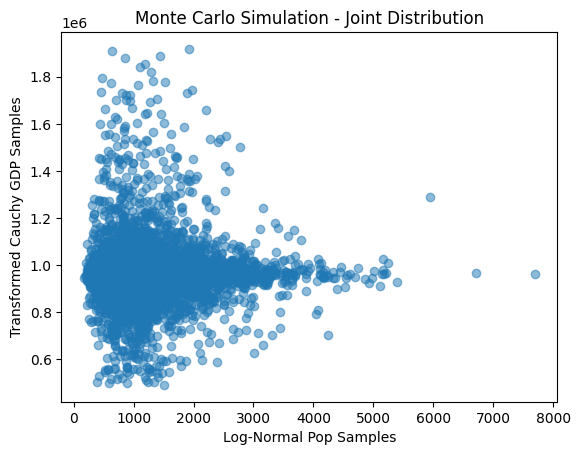

In [55]:
import matplotlib.pyplot as plt

# Scatter plot for joint distribution
plt.scatter(samples_x, samples_y, alpha=0.5)
plt.xlabel('Log-Normal Pop Samples')
plt.ylabel('Transformed Cauchy GDP Samples')
plt.title('Monte Carlo Simulation - Joint Distribution')
plt.show()

In [56]:
joint_samples = np.column_stack((samples_x, samples_y))
print(joint_samples)

[[1.41325252e+03 9.85704646e+05]
 [9.73366431e+02 9.70961252e+05]
 [9.09218949e+02 9.44898797e+05]
 ...
 [2.02865999e+03 9.48395329e+05]
 [5.69474090e+02 9.18650281e+05]
 [5.84078307e+02 9.28992951e+05]]


In [69]:
pop_digitized = np.digitize(joint_samples[:, 0], bin_edges)  # Population bins
gdp_digitized = np.digitize(joint_samples[:, 1], bin_edges1)

joint_counts = np.zeros((len(bin_edges), len(bin_edges1)))

# 3. Count the occurrences of each population and GDP pair falling into the bins
for i in range(len(joint_samples)):
    pop_bin = pop_digitized[i] - 1  # -1 because np.digitize returns bin index starting from 1
    gdp_bin = gdp_digitized[i] - 1  # Adjust to 0-indexed for array access

    if 0 <= pop_bin < len(bin_edges) and 0 <= gdp_bin < len(bin_edges1):
        joint_counts[pop_bin, gdp_bin] += 1

# 4. Calculate the conditional probabilities P(Pop | GDP)
gdp_totals = np.sum(joint_counts, axis=0)  # Total counts for each GDP bin

# Avoid division by zero in case a GDP bin has no samples
conditional_probs = np.zeros_like(joint_counts)
for gdp_bin in range(len(bin_edges1)):
    if gdp_totals[gdp_bin] > 0:
        conditional_probs[:, gdp_bin] = joint_counts[:, gdp_bin] / gdp_totals[gdp_bin]

# conditional_probs now contains P(Pop | GDP) for each bin
print("Conditional probabilities (P(Pop | GDP)): \n", conditional_probs)


Conditional probabilities (P(Pop | GDP)): 
 [[0.08571429 0.10714286 0.16152331 0.16374885 0.12398922 0.17708333
  0.21428571 0.1875     0.10526316 0.22222222 0.        ]
 [0.38571429 0.3877551  0.32698621 0.32736607 0.33153639 0.3125
  0.28571429 0.28125    0.47368421 0.         0.5       ]
 [0.31428571 0.27040816 0.22718319 0.23983151 0.26954178 0.25
  0.16071429 0.25       0.21052632 0.55555556 0.        ]
 [0.12857143 0.11734694 0.15167433 0.13215743 0.12398922 0.16666667
  0.17857143 0.09375    0.10526316 0.11111111 0.25      ]
 [0.04285714 0.04591837 0.06894288 0.06976438 0.0916442  0.04166667
  0.125      0.03125    0.10526316 0.11111111 0.25      ]
 [0.01428571 0.02040816 0.03217334 0.03264446 0.02425876 0.03125
  0.03571429 0.125      0.         0.         0.        ]
 [0.01428571 0.0255102  0.01707157 0.01934974 0.01617251 0.
  0.         0.03125    0.         0.         0.        ]
 [0.01428571 0.01020408 0.00459619 0.00618665 0.01078167 0.01041667
  0.         0.         0. 

In [70]:
d1 = Categorical([[0.0010, 0.1160, 0.3280, 0.2580, 0.1620, 0.0650, 0.0360, 0.0200, 0.0060,
         0.0040, 0.0040]])

In [71]:
d2 = ConditionalCategorical(probs=np.array([conditional_probs], dtype=np.float32))

print(d2.probs)

ParameterList(  (0): Parameter containing: [torch.float32 of size 11x11])


In [72]:
model2 = BayesianNetwork()
model2.add_distributions([d1, d2])
model2.add_edge(d1, d2)

In [73]:
print(model2)

BayesianNetwork(
  (distributions): ModuleList(
    (0): Categorical()
    (1): ConditionalCategorical(
      (probs): ParameterList(  (0): Parameter containing: [torch.float32 of size 11x11])
      (_w_sum): [tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
      (_xw_sum): [tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]
      (_log_probs): [tensor([[-2.4567, -2.2336, -1.8231, -1.80

In [74]:
# Your synthetic training data (Population and GDP categories)
X = np.random.randint(2, size=(2, 2))
# Now fit the model
model2.fit(X)

# Inference (example: predicting GDP given Population)
# evidence = np.array([[2.0, np.nan]])  # Evidence: Population category is 2, GDP is unknown (np.nan)

# # Perform prediction
# prediction = model2.predict(evidence)

# print("Predicted GDP category for Population 2:", prediction)

BayesianNetwork(
  (distributions): ModuleList(
    (0): Categorical()
    (1): ConditionalCategorical(
      (probs): ParameterList(  (0): Parameter containing: [torch.float32 of size 11x11])
      (_w_sum): [tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
      (_xw_sum): [tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
              [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]
      (_log_probs): [tensor([[   -inf,  0.0000,    -inf,    -i